**IMPORT**

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt

import keras.applications as kapp  
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM 
# try:
#     import tensorflow as tf
# except:
#     import traceback
#     traceback.print_exc()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
     
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
# plt.style.use("ggplot")

Using plaidml.keras.backend backend.


**DATA INGESTION AND EXPLORATION**

In [2]:
# df_portfolio = pd.read_csv("portfolio_template.csv")
# df_portfolio.info()

In [3]:
def stock_dataframe(name: str = "stock/ticker symbol"):
    _stock_info = yf.Ticker(name)
    df = _stock_info.history(period="max")
    df = df.drop(['Dividends','Stock Splits'], axis=1)
    df = df[df.index>'1990-01-01'][df.index<'2020-03-01']
    df = df[df['Volume']>0]
    # df['Year-Week'] = df.index.strftime('%d-%U-%Y')
    # df = df.set_index('Year-Week')
    return df

def plot_close_price(df):
    df.plot.line(y="Close",use_index=True,)

def get_all_sub_df(df,divs):
    no_of_plots = int(df.count()[0]/divs)
    fig, axs = plt.subplots(int(no_of_plots/2)+1, 2, figsize=(80, 80))
    fig.suptitle('Vertically stacked subplots')
    _count=1
    for i in range(no_of_plots):
        _df = df.iloc[i*divs:i*divs+divs]
        if _count==1:
            axs[i//2][0].plot(_df.index, _df['Close'])
            axs[i//2][0].set_xticklabels(_df.index,rotation=45, ha='right')
            _count+=1
        else:
            axs[i//2][1].plot(_df.index, _df['Close'])
            axs[i//2][1].set_xticklabels(_df.index,rotation=45, ha='right')
            _count = 1
    
    plt.savefig('foo.png', bbox_inches='tight')

def get_sub_df(df,divs,separate: bool = False):
    no_of_plots = int(df.count()[0]/divs)
    script_dir = os.path.curdir
    results_dir = os.path.join(script_dir, 'Outputs/')

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
        
    plt.figure(figsize = (40,20))
    if not separate:
        plt.plot(df.index, df['Close'])
        plt.xticks(rotation=90)
        file_name = "boo.png"
        plt.savefig(results_dir+file_name, bbox_inches='tight')
        return

    for i in range(no_of_plots):
        _df = df.iloc[i*divs:i*divs+divs]
        plt.plot(_df.index, _df['Close'])
        plt.xticks(rotation=45)
        file_name = f"par{i}.png"
        plt.savefig(results_dir+file_name, bbox_inches='tight')
        plt.clf()

def get_pred(df):
    train_size = int(len(df) * 0.8)
    train_set = df.iloc[:train_size,:]
    test_set = df.iloc[train_size:,:]

    scaler = MinMaxScaler(feature_range=(0,1))
    train_set_scaled = scaler.fit_transform(train_set)
    test_set_scaled = scaler.transform(test_set)

    def create_dataset(dataset, lookback=1):
        X, y = [], []
        for i in range(lookback, len(dataset)):
            X.append(dataset[i-lookback:i, 0])
            y.append(dataset[i, 0])
        return np.array(X), np.array(y)

    lookback = 60
    X_train, y_train = create_dataset(train_set_scaled, lookback)
    X_test, y_test = create_dataset(test_set_scaled, lookback)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X_train, y_train, epochs=50, batch_size=64)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print("Root Mean Squared Error: {:.2f}".format(rmse))

    # Scale the predictions back to the original range
    # y_pred = scaler.inverse_transform(y_pred)
    # y_test = scaler.inverse_transform(y_test)
    # print(y_pred)
    # print(y_test)   

    final_df = pd.DataFrame({"test":list(y_test),'pred':[float(i) for i in y_pred]})
    final_df["RMSE"] = np.sqrt(np.mean((final_df['pred'] - final_df['test'])**2))
    plt.plot(df.index[1438:],final_df['pred'],"r",df.index[1438:],final_df['test'])
    plt.legend()
    return(model)

Epoch 1/50
1318/1318 [==============================] - 3s 2ms/step - loss: 0.0658
Epoch 2/50
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0061
Epoch 3/50
1318/1318 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 4/50
1318/1318 [==============================] - 2s 2ms/step - loss: 7.1128e-04
Epoch 5/50
1318/1318 [==============================] - 2s 2ms/step - loss: 6.6526e-04
Epoch 6/50
1318/1318 [==============================] - 2s 1ms/step - loss: 6.7972e-04
Epoch 7/50
1318/1318 [==============================] - 2s 1ms/step - loss: 6.4993e-04
Epoch 8/50
1318/1318 [==============================] - 2s 1ms/step - loss: 6.4662e-04
Epoch 9/50
1318/1318 [==============================] - 2s 1ms/step - loss: 6.4088e-04
Epoch 10/50
1318/1318 [==============================] - 2s 1ms/step - loss: 6.5088e-04
Epoch 11/50
1318/1318 [==============================] - 2s 1ms/step - loss: 6.3382e-04
Epoch 12/50
1318/1318 [==============================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Root Mean Squared Error: 0.11


SyntaxError: 'return' outside function (2308384067.py, line 60)

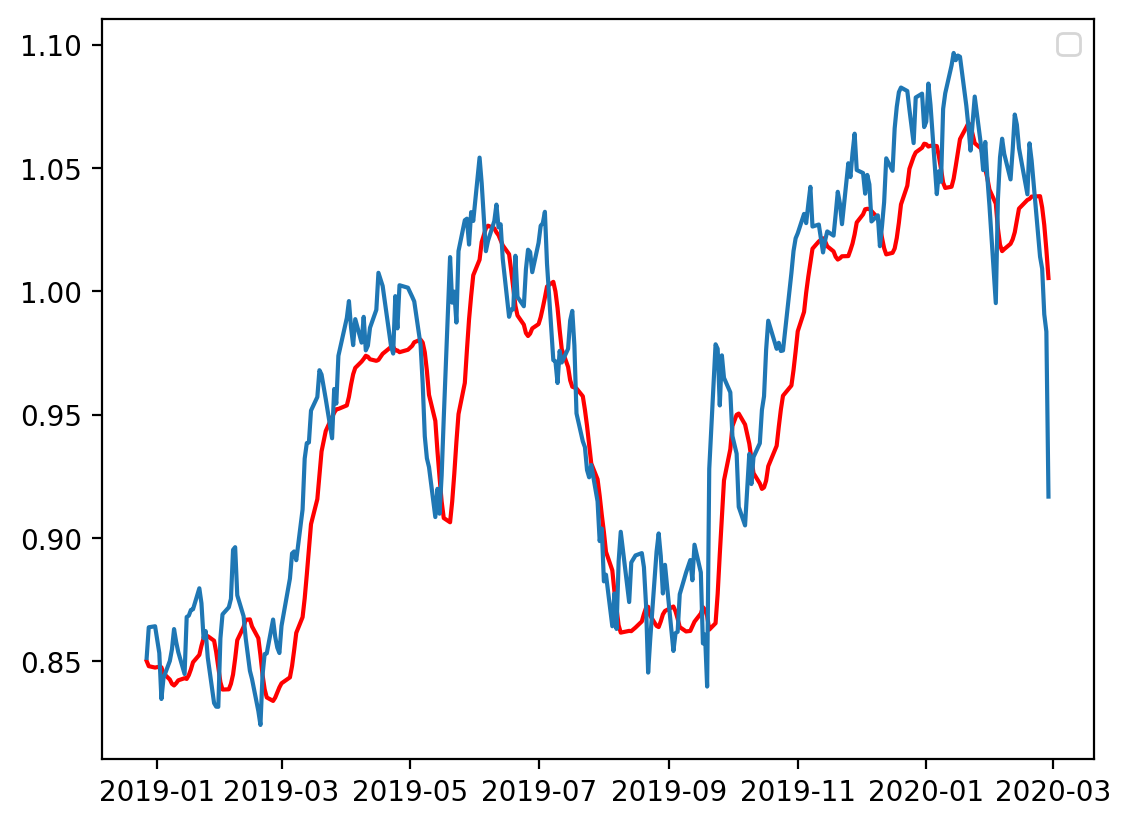

In [7]:
df = stock_dataframe("^NSEI")
df = df['Close']
type(df)
df = pd.DataFrame(df)
# df = df.drop(['Open','High','Low','Volume'],axis=1)
# model = get_pred(df)
train_size = int(len(df) * 0.8)
train_set = df.iloc[:train_size,:]
test_set = df.iloc[train_size:,:]

scaler = MinMaxScaler(feature_range=(0,1))
train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)

def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Create the training and testing datasets
lookback = 60
X_train, y_train = create_dataset(train_set_scaled, lookback)
X_test, y_test = create_dataset(test_set_scaled, lookback)

# Reshape the datasets to be compatible with LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Make predictions on the testing dataset
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE) of the predictions
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print("Root Mean Squared Error: {:.2f}".format(rmse))

# Scale the predictions back to the original range
# y_pred = scaler.inverse_transform(y_pred)
# y_test = scaler.inverse_transform(y_test)
# print(y_pred)
# print(y_test)   

final_df = pd.DataFrame({"test":list(y_test),'pred':[float(i) for i in y_pred]})
final_df["RMSE"] = np.sqrt(np.mean((final_df['pred'] - final_df['test'])**2))
plt.plot(df.index[1438:],final_df['pred'],"r",df.index[1438:],final_df['test'])
plt.legend()

In [5]:
# get_sub_df(df,90)
# get_all_sub_df(df,90)
# get_sub_df(df,90,True)

In [6]:
# df = stock_dataframe("BTC-USD")
# df = df.reset_index()
# df.plot(legend=True, subplots=True, figsize=(12,6))
# mov_avg =[10,50,100]

# for i in mov_avg:
#     col_name = f"MA_{i}"
#     df[col_name] = pd.DataFrame.rolling(df['Close'],i).mean()

# df["Daily Return"] = df['Close'].pct_change()
# df['Daily Return'].plot(figsize=(12,5),legend=True, linestyle=":", marker='o')
# plt.show()
# sns.distplot(df["Daily Return"].dropna(),bins=100, color='green')
# plt.show()

# date = pd.DataFrame(df['Date'])
# closing_df1 = pd.DataFrame(df['Close'])
# close1 = closing_df1.rename(columns={'Close':'data_close'})
# close2 = pd.concat([df,close1],axis=1)
# close2.head()

# df.reset_index(drop=True, inplace=True)
# df.fillna(df.mean(), inplace=True)
# df.head()
# df.nunique()
# df.sort_index(axis=1,ascending=True)

# cols_plot = ['Open','High','Low','Close','Volume','MA_10','MA_50','MA_100', 'Daily Return']
# axes = df[cols_plot].plot(marker='.',alpha=0.7, linestyle='None', figsize=(11,9),subplots=True)
# for i in axes:
#     i.set_ylabel('Daily trade')

# plt.plot(df['Close'],label='Close Price')
# plt.xlabel('Timestamp')
# plt.ylabel('Closing Price')
# plt.savefig('./Outputs/data_viz.png', bbox_inches='tight')
# print(df)
# df.isnull().sum()

In [10]:
final_df["RMSE"].mean()

0.030480576543642078

In [11]:
from sklearn.metrics import mean_absolute_error

In [13]:
mean_absolute_error(y_test,y_pred,)

0.024420229438925925